In [4]:
import torch
import torch.nn as nn
from torchinfo import summary
from tqdm import tqdm

In [5]:
from src.loss import snn_loss

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [121]:
encoder = nn.Sequential(
    nn.Linear(110, 256),
    nn.ReLU(),
    nn.Linear(256, 50)
).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
losses = []
for _ in range(10):
    with tqdm(range(100)) as bar:
        for _ in bar:
            z = torch.randn(128, 100).to(device)
            label = torch.randint(0, 10, (128,)).to(device)
            label_onehot = nn.functional.one_hot(label, 10).to(device)
            z_c = encoder(torch.cat([z, label_onehot], dim=-1))
            loss = snn_loss(z_c, label, 0.2)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            bar.set_postfix(loss=loss.item())
            losses.append(loss.item())


100%|██████████| 100/100 [00:00<00:00, 250.00it/s, loss=0.0454]


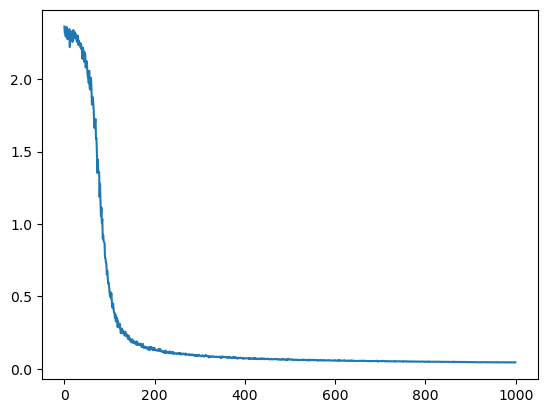

In [122]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [123]:
encoder.eval()
z_cs = []
labels = []
with torch.no_grad():
    for i in range(10):
        z = torch.randn(128, 100).to(device)
        label = torch.randint(0, 10, (128,)).to(device)
        label_onehot = nn.functional.one_hot(label, 10).to(device)
        z_c = encoder(torch.cat([z, label_onehot], dim=-1))

        z_cs.append(z_c)
        labels.append(label)
z_cs = torch.cat(z_cs, dim=0)
labels = torch.cat(labels, dim=0)

In [124]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_cs_tsne = tsne.fit_transform(z_cs.cpu().numpy())

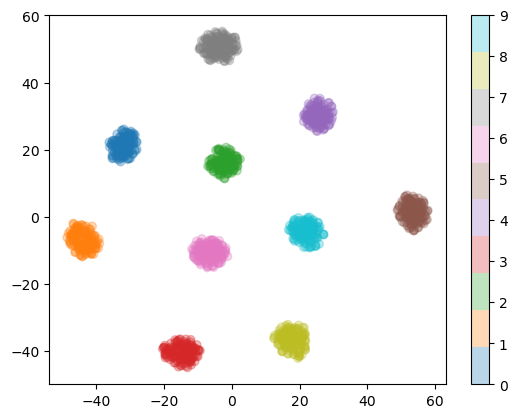

In [125]:
import matplotlib.pyplot as plt

plt.scatter(z_cs_tsne[:, 0], z_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')